# [CDAF] Atividade 2

## Nome e matrícula
Nome: Luís Felipe Ramos Ferreira
Matrícula: 2019022553

## Introdução
Nesta atividade, vamos revisar os conceitos aprendidos em sala de aula sobre estatísticas agregadas. Para esta atividade, usaremos dados do Brasileirão 2022 do FBRef.

## Questão 1
- Baixe o dataset de resultados em https://fbref.com/en/comps/24/2022/schedule/2022-Serie-A-Scores-and-Fixtures
- Crie uma média móvel de 5 jogos, para cada equipe, de cada uma das seguintes estatísticas: xG pró, xG contra, e dif. xG.
- Escolha 4 times para visualizar a série temporal das estatísticas acima. Uma visualização para cada uma das estatísticas, onde a média geral do campeonato é apresentada com uma linha pontilhada em conjunto com a média móvel dos times escolhidos.
- Interprete os resultados. O que isso pode indicar sobre a qualidade ofensiva e defensiva dos times escolhidos?

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import stats
from mplsoccer import PyPizza, FontManager
warnings.filterwarnings('ignore')

In [49]:
df: pd.DataFrame = pd.read_csv("../data/sportsref.csv")
df.drop(columns=["Day", "Time", "Date", "Attendance", "Venue", "Referee", "Match Report", "Notes"], inplace=True)
df.rename(columns={"xG": "xG_Home", "xG.1": "xG_Away"}, inplace=True)
df["xG_diff"] = df["xG_Home"] - df["xG_Away"]
df

,Wk,Home,xG_Home,Score,xG_Away,Away,xG_diff
0,1,Fluminense,1.6,0–0,0.1,Santos,1.5
1,1,Atl Goianiense,1.4,1–1,1.2,Flamengo,0.2
2,1,Coritiba,1.7,3–0,0.4,Goiás,1.3
3,1,Atlético Mineiro,1.9,2–0,0.6,Internacional,1.3
4,1,Botafogo (RJ),1.5,1–3,2.1,Corinthians,-0.6
...,...,...,...,...,...,...,...
375,38,Bragantino,0.9,0–1,0.6,Fluminense,0.3
376,38,América (MG),2.1,1–1,0.5,Atl Goianiense,1.6
377,38,Goiás,0.2,0–4,1.7,São Paulo,-1.5
378,38,Internacional,1.4,3–0,1.3,Palmeiras,0.1


In [50]:
teams: np.array = df["Home"].unique()
xG_pro_global_moving_average: np.array = np.zeros(38)
xG_against_global_moving_average: np.array = np.zeros(38)
xG_diff_global_moving_average: np.array = np.zeros(38)
window_size: int = 5
for team in teams:
    team_df: pd.DataFrame = df[(df["Home"] == team) | (df["Away"] == team)]
    team_df["xG_pro"] = np.where(team_df["Home"] == team, team_df["xG_Home"], team_df["xG_Away"])
    team_df["xG_against"] = np.where(team_df["Home"] == team, team_df["xG_Away"], team_df["xG_Home"])
    team_df["xG_diff"] = np.where(team_df["Home"] == team, team_df["xG_diff"], -1 * team_df["xG_diff"])

    xG_pro_moving_average: np.array = team_df["xG_pro"].rolling(window=window_size, min_periods=1).mean().to_numpy()
    xG_against_moving_average: np.array = team_df["xG_against"].rolling(window=window_size, min_periods=1).mean().to_numpy()
    xG_diff_moving_average: np.array = team_df["xG_diff"].rolling(window=window_size, min_periods=1).mean().to_numpy()

    """ plt.plot(np.arange(38), xG_pro_moving_average,  marker='o', linewidth=1, markersize=2, label="Pro")
    plt.plot(np.arange(38), xG_against_moving_average, marker='o', linewidth=1, markersize=2, label="Against")
    plt.plot(np.arange(38), xG_diff_moving_average,  marker='o', linewidth=1, markersize=2, label="Difference")
    plt.title(f"{team} moving averages")
    plt.xticks(np.arange(38, step=2))
    plt.xlabel("Week")
    plt.ylabel("xG")
    plt.legend()
    plt.show() """

    xG_pro_global_moving_average += xG_pro_moving_average
    xG_against_global_moving_average = xG_against_moving_average
    xG_diff_global_moving_average += xG_diff_moving_average

xG_pro_global_moving_average /= 20
xG_against_global_moving_average /= 20
xG_diff_global_moving_average /= 20


Para análise, foram escolhidos os clubes que ficaram em 1º, 7º, 13º e 20º colocados no campeonato brasileiro de 2022, uma vez que são clubes espaçados em colocação de forma balanceada, o que irá permitir análises de diferentes casos de performance durante o campeonato. Respectivamente, se tratam dos clubes: Palmeiras, Atlético Mineiro, Goiás e Juventude.

In [51]:
def plot_teams_moving_averages(df: pd.DataFrame, statistic: str, teams: np.array, global_moving_average: np.array, window_size: int) -> None:
    for team in teams:
        team_df: pd.DataFrame = df[(df["Home"] == team) | (df["Away"] == team)]
        team_df["xG_pro"] = np.where(team_df["Home"] == team, team_df["xG_Home"], team_df["xG_Away"])
        team_df["xG_against"] = np.where(team_df["Home"] == team, team_df["xG_Away"], team_df["xG_Home"])
        team_df["xG_diff"] = np.where(team_df["Home"] == team, team_df["xG_diff"], -1 * team_df["xG_diff"])

        xG_pro_moving_average: np.array = team_df[statistic].rolling(window=window_size, min_periods=1).mean().to_numpy()
        plt.plot(np.arange(38), xG_pro_moving_average,  marker='o', linewidth=1, markersize=2, label=team)
        
    plt.plot(np.arange(38), global_moving_average,  linestyle="--", marker='o', linewidth=1, markersize=2, label="Global average")
    plt.title(f"Moving average of {statistic} for {teams}")
    plt.xticks(np.arange(38, step=2))
    plt.xlabel("Week")
    plt.ylabel("xG")
    plt.legend(loc=(0.1, 0.775), fontsize="6.5")
    plt.show()

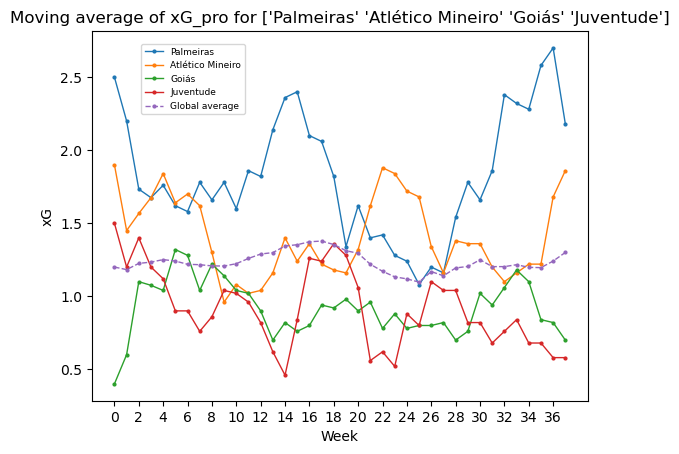

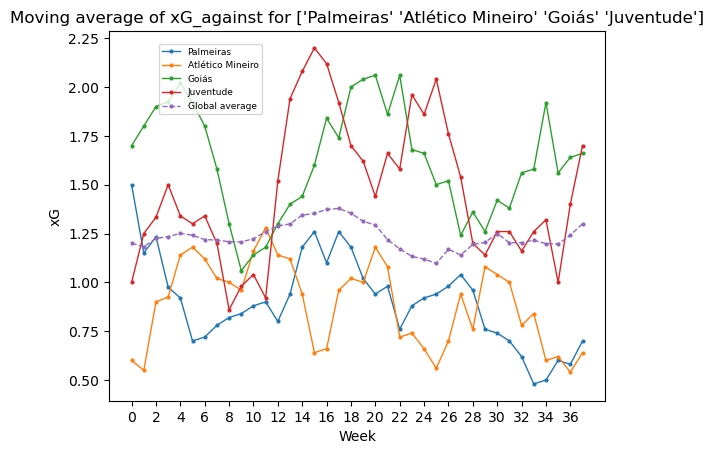

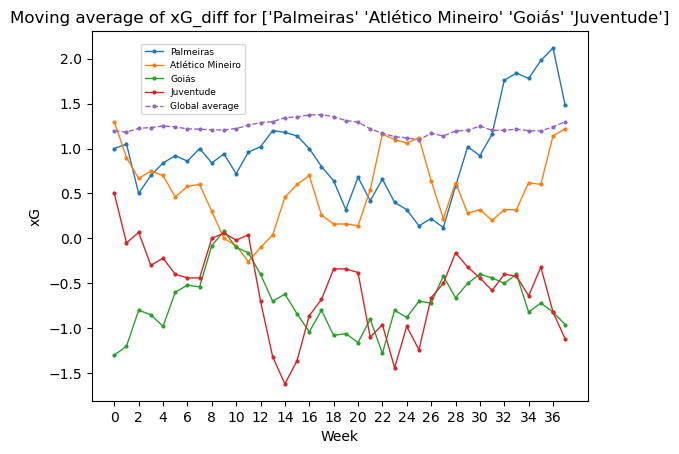

In [52]:
teams: np.array = np.array(["Palmeiras", "Atlético Mineiro", "Goiás", "Juventude"])
statistics: np.array = np.array(["xG_pro", "xG_against", "xG_diff"])
for statistic in statistics:
    plot_teams_moving_averages(df=df, statistic=statistic, teams=teams, global_moving_average=xG_pro_global_moving_average, window_size=window_size)


Em um primeiro momento, é interessante analisar como a média móvel de *xG_pro* e *xG_against* acompanham a posição relativa dos times no campeonato. O Palmeiras, como campeão, está com uma média praticamente sempre "acima" dos outros clubes analisados no quesito gols esperados a favor, enquanto, análogamente, está quase sempre "abaixo" dos outros em relação a gols esperados contra. A mesma situação se repete para o Juventude, último colocado, só que de maneira inversa, conforme podemos esperar. Evidentemente, isso não estabelece uma regra. O Atlético Mineiro, 7º colocado, teve uma média de *xG_against* muito parecida com a do Palmeiras, assim como também teve períodos ao longo do campeonato em que sua média de *xG_pro* foi superior à do campeão.

Em relação ao desempenho dos times, fica claro que aqueles que estão na parte de cima da tabela possuem maior qualidade, tanto ofensivamente quanto defensivamente. Pode-se ver como o Palmeiras e o Atlético Mineiro tem suas séries de médias móveis de *xG_pro* acima da média global e *xG_against* abaixo da média global, de maneira generalizada. O mesmo ocorre de maneira inversa para Goiás e Juventude. Podemos inferir disso então que clubes que ficaram em boas colocações no campeonato possuem proporções de gols feitos esperados acima da média e gols tomados esperados abaixo da média.

O gráfico da média móvel de *xG_diff* nos mostra qye todos os clubes ficaram, praticamente todo o tempo, abaixo do valor médio global, que está em cada período de análise entre 1.0 e 1.5. Disso, podemos ver como o modelo utilizado pode superestimar o número de gols feitos pelo time vencedor de uma partida e subestimar o número de gols feitos pelo time perdedor.

FALAR MAIS AQUI

## Questão 2
- Agora repita a questão 1, plotando as séries temporais dos mesmos times, mas para uma janela móvel de 10 jogos.
- Quais as diferenças entre as séries temporais de 5 e 10 jogos? Em quais situações pode ser vantajoso escolher uma janela à outra?

In [53]:
teams: np.array = df["Home"].unique()
xG_pro_global_moving_average: np.array = np.zeros(38)
xG_against_global_moving_average: np.array = np.zeros(38)
xG_diff_global_moving_average: np.array = np.zeros(38)
window_size: int = 10
for team in teams:
    team_df: pd.DataFrame = df[(df["Home"] == team) | (df["Away"] == team)]
    team_df["xG_pro"] = np.where(team_df["Home"] == team, team_df["xG_Home"], team_df["xG_Away"])
    team_df["xG_against"] = np.where(team_df["Home"] == team, team_df["xG_Away"], team_df["xG_Home"])
    team_df["xG_diff"] = np.where(team_df["Home"] == team, team_df["xG_diff"], -1 * team_df["xG_diff"])

    xG_pro_moving_average: np.array = team_df["xG_pro"].rolling(window=window_size, min_periods=1).mean().to_numpy()
    xG_against_moving_average: np.array = team_df["xG_against"].rolling(window=window_size, min_periods=1).mean().to_numpy()
    xG_diff_moving_average: np.array = team_df["xG_diff"].rolling(window=window_size, min_periods=1).mean().to_numpy()

    """ plt.plot(np.arange(38), xG_pro_moving_average,  marker='o', linewidth=1, markersize=2, label="Pro")
    plt.plot(np.arange(38), xG_against_moving_average, marker='o', linewidth=1, markersize=2, label="Against")
    plt.plot(np.arange(38), xG_diff_moving_average,  marker='o', linewidth=1, markersize=2, label="Difference")
    plt.title(f"{team} moving averages")
    plt.xticks(np.arange(38, step=2))
    plt.xlabel("Week")
    plt.ylabel("xG")
    plt.legend()
    plt.show() """

    xG_pro_global_moving_average += xG_pro_moving_average
    xG_against_global_moving_average = xG_against_moving_average
    xG_diff_global_moving_average += xG_diff_moving_average

xG_pro_global_moving_average /= 20
xG_against_global_moving_average /= 20
xG_diff_global_moving_average /= 20

Os mesmos 4 clubes serão escolhidos, pelo mesmo motivo anterior.

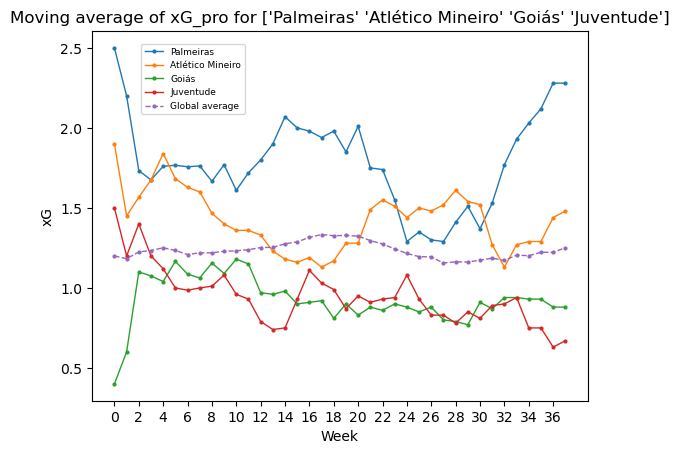

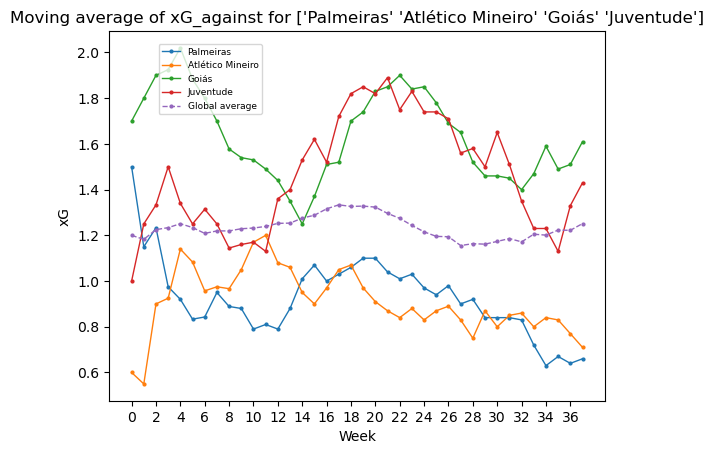

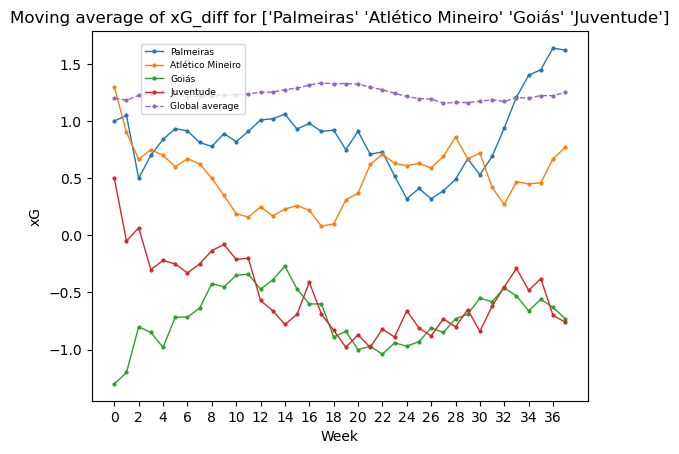

In [54]:
statistics: np.array = np.array(["xG_pro", "xG_against", "xG_diff"])
teams: np.array = np.array(["Palmeiras", "Atlético Mineiro", "Goiás", "Juventude"])
for statistic in statistics:
    plot_teams_moving_averages(df=df, statistic=statistic, teams=teams, global_moving_average=xG_pro_global_moving_average, window_size=window_size)

A janela temporal de 10 jogos traz um grau de informação maior, uma vez que mais jogos são utilizados no cálculo da média representativa de cada período de análise da série temporal gerada.

## Questão 3
- Vá para o link
-- https://fbref.com/en/comps/24/2022/stats/2022-Serie-A-Stats
- Nesta seção de estatísticas, é possível navegar por estatísticas específicas para diferentes aspectos do jogo (finalização, passe, defesa, etc.). Para todos exercícios à partir deste, você terá que selecionar aquelas que julgar mais relevantes para responder as questões.
- Monte um radar plot com 6 atributos relevantes para atacantes e compare 3 jogadores de sua escolha. Justifique a escolha de cada um dos atributos, a escolha da escala dos radares e o tipo de normalização. Interprete os resultados dos radares em termos das qualidades e limitações dos jogadores.
- Ref Soccermatics:
-- https://soccermatics.readthedocs.io/en/latest/lesson3/ScoutingPlayers.html
-- https://soccermatics.readthedocs.io/en/latest/gallery/lesson3/plot_RadarPlot.html

Os 6 atributos relevantes escolhidos para atacantes e suas justificativas estão descritos a seguir:

- xG (Expected Goals): atacnate tem q fzr gol

- PrgC (Progressive Carries): podemos ver qatacantes com caracteristicas de arrancadas ao ver espaços abertos (bh, dudu, rony, hulk)

- PrgR (Progressive Passes Rec): habilidade de se posicionar para receber boas bolas e recebe las

- Gls p/ 90 - media de gols por partida, importante

- xG p/ 90 - quantos gols se espera por partida

- npxG (Non Penalty Expected Goals) - quao dependente de penaltis é esse jogador

Os três jogadores escolhidos serão:

- Gabriel Barbosa (Flamengo)

- Rony (Palmeiras)

- Hulk (Atlético Mineiro)

Como a temporada analisada é o campeonato brasileiro de 2022, acredito que seja interessante analisar os principais atacantes doo país nos últimos anos. Embora a temporada de 2022 não tenha sido a referência para alguns destes jogadores, como 2019 foi para Gabriel Barbosa, e 2021 para Hulk, estes continuaram sendo representações de craques para suas equipes e cumprindo com seus papéis de atacantes.

In [55]:
df: pd.DataFrame = pd.read_csv("../data/player_standard_stats.csv")
df.drop(columns=["Rk", "Nation", "Age", "Starts", "MP", "Born", "Min", "90s", "Matches", "-9999"], inplace=True) # removendo colunas "inúteis"
df.rename(columns={"Gls.1": "GlsP90", "Ast.1": "AstP90", "G+A.1": "G+AP90", "G-PK.1": "G-PKP90", "xG.1": "xGP90", "xAG.1": "xAGP90", "npxG.1": "npxGP90", "npxG+xAG.1": "npxG+xAGP90"}, inplace=True)
hulk_series: pd.Series = df[df["Player"] == "Hulk"]
gabigol_series: pd.Series = df[df["Player"] == "Gabriel Barbosa"]
rony_series: pd.Series = df[df["Player"] == "Rony"]

test = df[df["Pos"] == "FW"].describe()[["xG", "npxG", "PrgC", "PrgR", "GlsP90", "xGP90"]]
test.loc["max"]



xG         18.40
npxG       18.40
PrgC      156.00
PrgR      309.00
GlsP90      3.10
xGP90       1.62
Name: max, dtype: float64

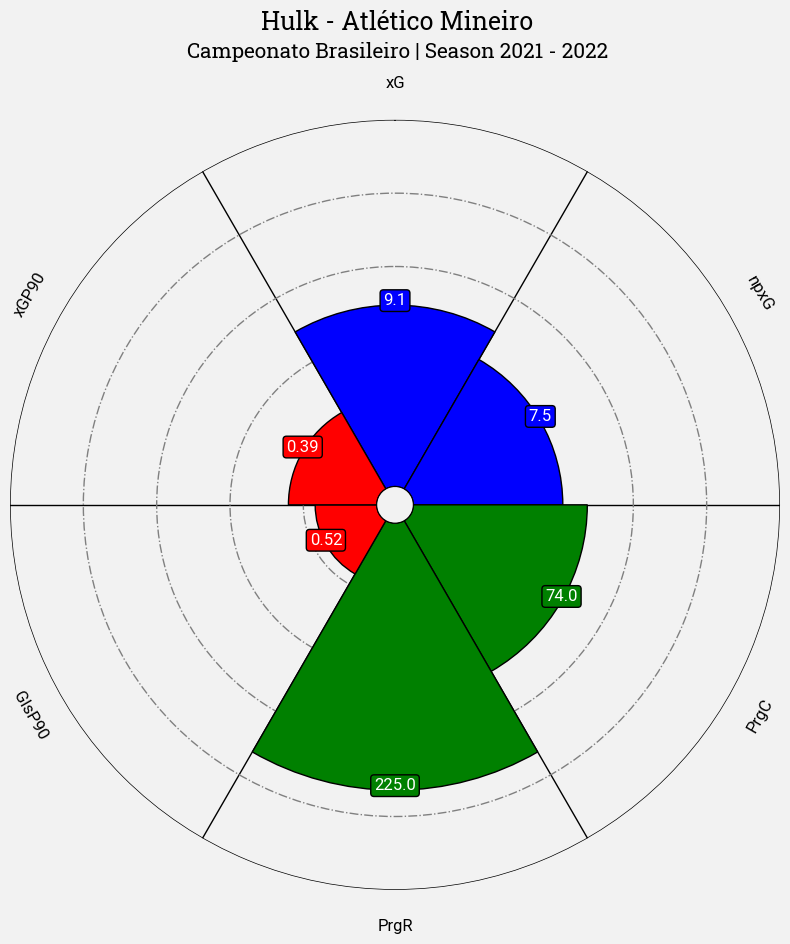

In [56]:
# código copiado do SoccerMatics

names = ["xG", "npxG", "PrgC", "PrgR", "GlsP90", "xGP90"]
values: np.array = hulk_series[names].to_numpy()[0]
values_normalized: np.array = np.round((values / test.loc["max"].to_numpy()) * 100, 2)
slice_colors = ["blue"] * 2 + ["green"] * 2 + ["red"] * 2
text_colors = ["white"]*6
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    params=names,
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    values_normalized,              # list of values
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Hulk - Atlético Mineiro", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Campeonato Brasileiro | Season 2021 - 2022",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)
plt.show()

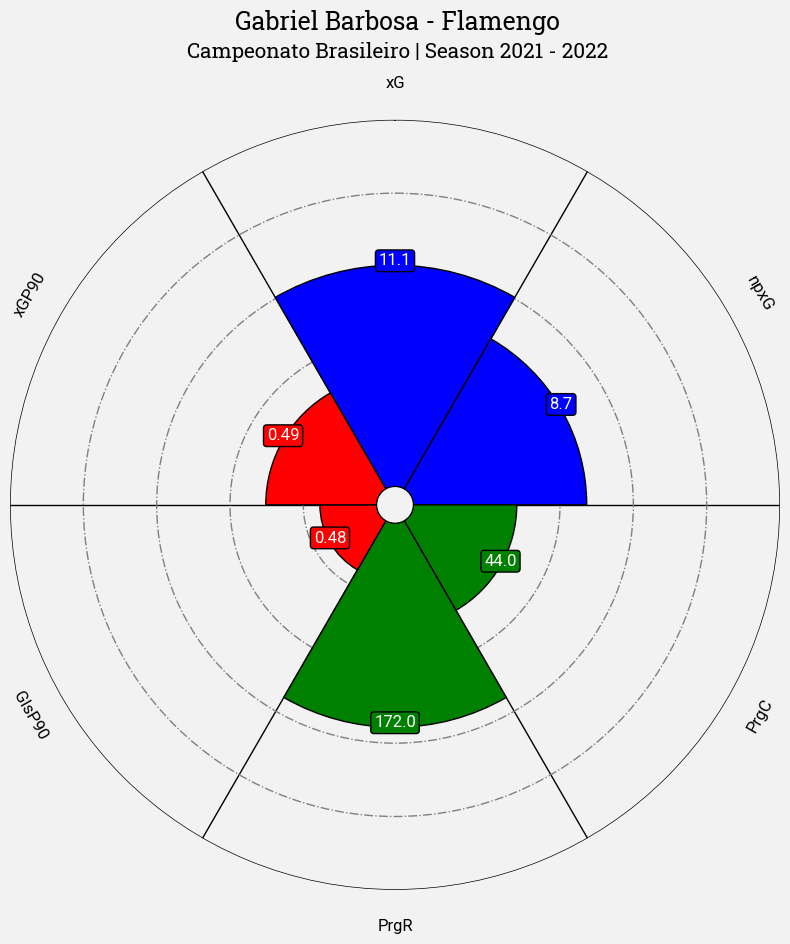

In [57]:
names = ["xG", "npxG", "PrgC", "PrgR", "GlsP90", "xGP90"]
values: np.array = gabigol_series[names].to_numpy()[0]
values_normalized: np.array = np.round((values / test.loc["max"].to_numpy()) * 100, 2)
slice_colors = ["blue"] * 2 + ["green"] * 2 + ["red"] * 2
text_colors = ["white"]*6
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    params=names,
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    values_normalized,              # list of values
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Gabriel Barbosa - Flamengo", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Campeonato Brasileiro | Season 2021 - 2022",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)
plt.show()

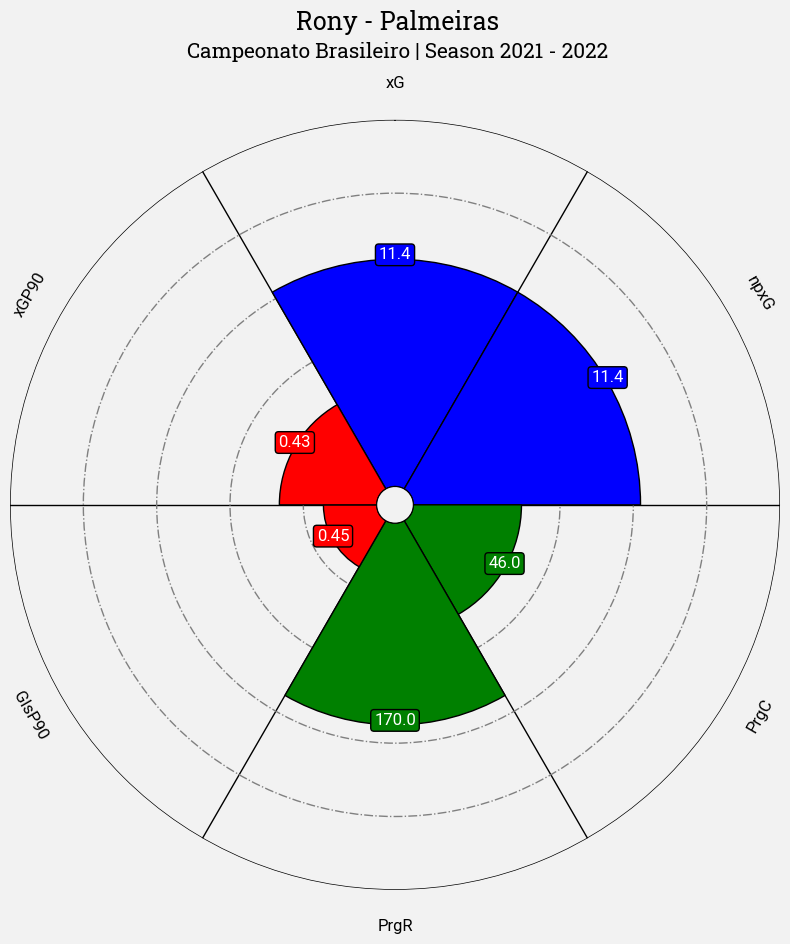

In [58]:
names = ["xG", "npxG", "PrgC", "PrgR", "GlsP90", "xGP90"]
values: np.array = rony_series[names].to_numpy()[0]
values_normalized: np.array = np.round((values / test.loc["max"].to_numpy()) * 100, 2)
slice_colors = ["blue"] * 2 + ["green"] * 2 + ["red"] * 2
text_colors = ["white"]*6
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    params=names,
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    values_normalized,              # list of values
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Rony - Palmeiras", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Campeonato Brasileiro | Season 2021 - 2022",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)
plt.show()

## Questão 4
- Faça o mesmo que na questão 3, mas para meio campistas.

Os 6 atributos relevantes escolhidos para atacantes e suas justificativas estão descritos a seguir:

- xG (Expected Goals): atacnate tem q fzr gol

- PrgC (Progressive Carries): podemos ver qatacantes com caracteristicas de arrancadas ao ver espaços abertos (bh, dudu, rony, hulk)

- PrgR (Progressive Passes Rec): habilidade de se posicionar para receber boas bolas e recebe las

- Gls p/ 90 - media de gols por partida, importante

- xG p/ 90 - quantos gols se espera por partida

- npxG (Non Penalty Expected Goals) - quao dependente de penaltis é esse jogador

Os três jogadores escolhidos serão:

- Giorgian De Arrascaeta (Flamengo)

- Raphael Veiga (Palmeiras)

- Matías Zaracho (Atlético Mineiro)

O argumento para a escolha destes três meio campistas é idêntico ao usado anteriormente. São jogadores fundamentais para seus clubes cujos desempenhos têm estado acima das demais equipes do país nos últimos anos.

## Questão 5
- Faça o mesmo que na questão 3, mas para zagueiros.

Os 6 atributos relevantes escolhidos para atacantes e suas justificativas estão descritos a seguir:

- xG (Expected Goals): atacnate tem q fzr gol

- PrgC (Progressive Carries): podemos ver qatacantes com caracteristicas de arrancadas ao ver espaços abertos (bh, dudu, rony, hulk)

- PrgR (Progressive Passes Rec): habilidade de se posicionar para receber boas bolas e recebe las

- Gls p/ 90 - media de gols por partida, importante

- xG p/ 90 - quantos gols se espera por partida

- npxG (Non Penalty Expected Goals) - quao dependente de penaltis é esse jogador

Os três jogadores escolhidos serão:

- David Luiz (Flamengo)

- Gustavo Gómez (Palmeiras)

- Júnior Alonso (Atlético Mineiro)

O argumento para a escolha destes três zagueiros é idêntico ao usado anteriormente. São jogadores fundamentais para seus clubes cujos desempenhos têm estado acima das demais equipes do país nos últimos anos.

## Questão 6
- Discuta as diferenças entre os radares das questões 3, 4 e 5. Quais são as principais diferenças entre os atributos relevantes para cada posição? Quais são as principais semelhanças? A impressão subjetiva que você tinha dos jogadores se comprovou pelos radares? Se não, por quê? Quais posições são mais difíceis de serem avaliadas por estatísticas?